<a href="https://colab.research.google.com/github/Kaz-K/medical-ai-radiology/blob/master/data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *医用画像処理の基本*

本資料はメディカルAI学会公認資格講座2020年版における医用画像解析「放射線画像」のための<u>**非公認**</u>の補足資料です。

**医用画像に対するData augmentation**についてソース・コードと共に解説します。

## 環境のセットアップ

### ライブラリのインストール

初めに、本補足資料において必要なPythonライブラリをインストールします。ライブラリは以下の通りです。

- **SimpleITK** : 医用画像を扱うための各種画像演算を扱うためのライブラリ

In [3]:
!pip install SimpleITK

     |████████████████████████████████| 42.5MB 96kB/s 


### サンプル画像のダウンロード

次のスクリプトを実行すると、Google colab上のホームディレクトリに`chest-xray.jpg`というファイル名でサンプル用の胸部X線写真がダウンロードされます。

注意：サンプル用のDICOM画像は以下のURLより取得したものを、Google colabからアクセス可能なGithub上のファイルとして配置し直したものです。

Chest radiograph - Wikipedia : https://en.wikipedia.org/wiki/Chest_radiograph

In [4]:
!curl -L -O https://github.com/Kaz-K/medical-ai-radiology/releases/download/v0.1/chest-xray.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   605    0   605    0     0   2813      0 --:--:-- --:--:-- --:--:--  2813
100  479k  100  479k    0     0   573k      0 --:--:-- --:--:-- --:--:-- 2374k


早速、画像ファイルを可視化して確認します。

画像ファイルをNumPy配列として読み込むことの出来る`imageio`を利用します。画像の解像度および画素値の範囲を確認し、更に`matplotlib`と呼ばれるライブラリを用いて画像を表示します。

画像の解像度:  (2197, 1920)
画素の最大値:  255
画素の最小値:  0


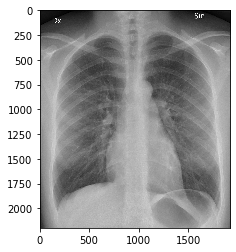

In [33]:
import imageio 
import numpy as np
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
image = imageio.imread('chest-xray.jpg', pilmode='L')
print('画像の解像度: ', image.shape)
print('画素の最大値: ', np.max(image))
print('画素の最小値: ', np.min(image))
ax.imshow(image, cmap='gray')
plt.grid(False)
plt.show()

## Data augmentationの基本

Data augmentationとは、データセットの各サンプルに対して人工的なノイズや幾何学的変換を付加することで、モデルに対して各種変換に対する不変性を獲得させ、性能の向上を図ることを言います。

ここでは、医用画像処理に特化したライブラリである`SimpleITK`を用いて、**拡大縮小**、**回転**、**フリップ**などの基本的な変換を実装します。

---
**注意** Data augmentationを提供するライブラリは数多くあり、代表的なものを以下に紹介します。

Albumentations: https://github.com/albumentations-team/albumentations  
batchgenerator: https://github.com/MIC-DKFZ/batchgenerators

### SimpleITKとnumpyの相互変換

次の関数`to_sitk`および`to_numpy`によって、SimpleITKとnumpyの相互の変換を定めます。更に、先程と同様に`matplotlib`を使って画像を表示するための関数を用意しておきます。

尚、`to_sitk`の関数中に出現する`SetSpacing`や`SetOrigin`の意味については、https://colab.research.google.com/github/Kaz-K/medical-ai-radiology/blob/master/notebooks/dicom_basics.ipynb を参照して下さい。

In [0]:
import SimpleITK as sitk 

def to_sitk(image, spacing=(1.0, 1.0), origin=(0.0, 0.0)):
    image = sitk.GetImageFromArray(image)
    image.SetSpacing(spacing)
    image.SetOrigin(origin)
    return image 


def to_numpy(image):
    return sitk.GetArrayFromImage(image)


def show_image(image):
    if isinstance(image, sitk.Image):
        image = to_numpy(image)
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    plt.grid(False)
    plt.show()

早速、先程読み込んだ`image`を`ToSimpleITK`によりSimpleITKの形式に変換します。

In [35]:
sitk_image = to_sitk(image)
print(sitk_image)

Image (0x3232080)
  RTTI typeinfo:   itk::Image<unsigned char, 2u>
  Reference Count: 1
  Modified Time: 811
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 0
  UpdateMTime: 0
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [1920, 2197]
  BufferedRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [1920, 2197]
  RequestedRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [1920, 2197]
  Spacing: [1, 1]
  Origin: [0, 0]
  Direction: 
1 0
0 1

  IndexToPointMatrix: 
1 0
0 1

  PointToIndexMatrix: 
1 0
0 1

  Inverse Direction: 
1 0
0 1

  PixelContainer: 
    ImportImageContainer (0x4280170)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, unsigned char>
      Reference Count: 1
      Modified Time: 812
      Debug: Off
      Object Name: 
      Observers: 
        none
      Pointer:

### SimpleITKによる画像の幾何学的変換の概要

続いて、`SimpleITK`を用いた画像の幾何学的変換を実装します。`SimpleITK`における画像の幾何学的変換は、次の2つのコンポーネントにより構成されます。

- **Transform** : 幾何学的変換それ自体を定めたもの
- **Resampler (Interpolator)** : 変換が施された画像を改めて格子状のpixelの配列に直す際のルールを定めたもの

本稿では、Resamplerを共通として、**拡大縮小**、**回転**、**フリップ**のそれぞれに相当するTransformを定義し、各種の変換を実装することとします。

---
**注意** Resamplerが必要となる理由は、例えば以下のホームページで視覚的に説明されています。

https://www.nicoladeinnocentis.it/en/resampling-theory

### Resamplerの実装

`SimpleITK`におけるResamplerは数多くの関数が用意されていますが、ここでは`sitkCosineWindowedSinc`というものを使います。

---
**注意** Resamplerの細かい種類については以下のホームページに使い方と共に解説されています。

http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/20_Expand_With_Interpolators.html


In [0]:
def resample(image, transform, default_value=0):
    reference_image = image
    interpolator = sitk.sitkCosineWindowedSinc
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)

### Transformの実装

**拡大縮小**、**回転**、**フリップ**のそれぞれに相当するTransformを定義します。尚、`scale`関数においては、magnitudeとして1未満の値を入力した際には視覚的な拡大、1以上の値を入力した際には視覚的な縮小が得られることに注意して下さい。

In [0]:
def scale(image, magnitude):
    image_size = image.GetSize()
    dimension = image.GetDimension()
    affine = sitk.AffineTransform(dimension)
    affine.SetCenter((image_size[0] // 2, image_size[1] // 2))
    affine.Scale((magnitude, magnitude))
    resampled = resample(image, affine)
    return resampled


def rotation(image, degree):
    image_size = image.GetSize()
    dimension = image.GetDimension()
    affine = sitk.AffineTransform(dimension)
    affine.SetCenter((image_size[0] // 2, image_size[1] // 2))
    radian = np.pi * degree / 180.
    affine.Rotate(axis1=0, axis2=1, angle=radian)
    resampled = resample(image, affine)
    return resampled


def horizontal_flip(image):
    image_size = image.GetSize()
    dimension = image.GetDimension()
    affine = sitk.AffineTransform(dimension)
    affine.SetCenter((image_size[0] // 2, image_size[1] // 2))
    affine.SetMatrix([1, 0, 0, -1])
    resampled = resample(image, affine)
    return resampled


def vertical_flip(image):
    image_size = image.GetSize()
    dimension = image.GetDimension()
    affine = sitk.AffineTransform(dimension)
    affine.SetCenter((image_size[0] // 2, image_size[1] // 2))
    affine.SetMatrix([-1, 0, 0, 1])
    resampled = resample(image, affine)
    return resampled

次のセルで、これらの幾何学的変換を実際に`sitk_image`に適応します。

In [0]:
scaled_image = scale(sitk_image, magnitude=0.5)
rotated_image = rotation(sitk_image, degree=30)
horizontal_flipped_image = horizontal_flip(sitk_image)
vertical_flipped_image = vertical_flip(sitk_image)

最後に、各画像を表示して結果を確認します。

Original


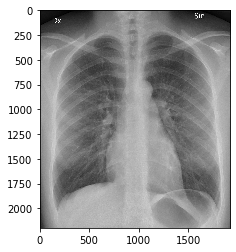

Scale


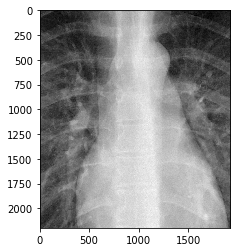

Rotation 


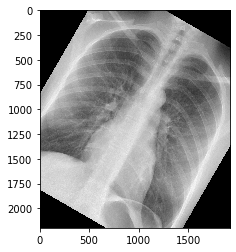

Horizontal flip


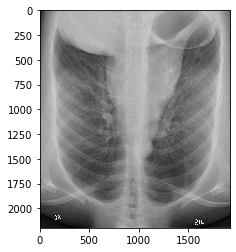

Vertical flip


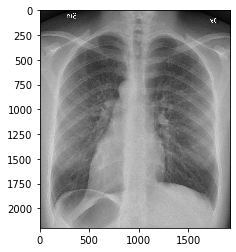

In [64]:
print('Original')
show_image(sitk_image)

print('Scale')
show_image(scaled_image)

print('Rotation ')
show_image(rotated_image)

print('Horizontal flip')
show_image(horizontal_flipped_image)

print('Vertical flip')
show_image(vertical_flipped_image)

公式サイトに`SimpleITK`を用いたData augmentationの更に詳しい解説がありますので、是非参考にして下さい。

https://simpleitk.github.io/SPIE2019_COURSE/03_data_augmentation.html